# Figure1 B-C-D-E

### Code structure
1B) Plot nuclear location of clones on a 6well plate (Day8).

1C) Histograms of number of cell divisions per clone seperated by days in culture.

1D-E) Contrast and crop images of KI67, FN1 and Dapi.

### Paths
All output paths are determined by the folder structure in the README.md. Input data has already been extracted from the raw data.

Last updated on: 2023-05-23

In [18]:
# Import all packages 
import numpy as np
import pandas as pd
import os as os
import seaborn as sns
import sys
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.transforms import Bbox
from skimage import data, exposure, img_as_float
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tifffile import imread
import glob
import cv2
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar



# Make plots look good 
%config InlineBackend.figure_format = 'svg'
sns.set_style("whitegrid")
sns.set_context("paper")

In [15]:
# Get current directory
cwd = os.getcwd()
cwd = cwd.split('Paper')[0]
print('Path to Paper folder: ', cwd)

Path to Paper folder:  /Volumes/GoogleDrive/My Drive/Hueros_Shared/


### 1B) Plot nuclear location of clones on a 6well plate (Day8).


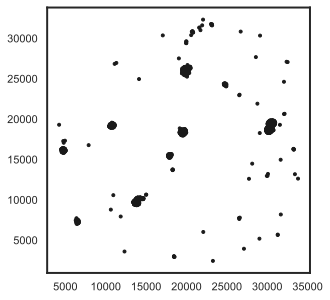

In [91]:
#Open image

path_im = cwd +"Paper/data/processed/RAR023/Day8/PositionTable/PositionTable_binary_20210422_012947_624__Plate20210422_STR_colonies_Phalloidin_IF_Ki67_day8_Well03_ChannelA647,GFP,DAPI_Seq0002_Stitched.txt"
data = pd.read_csv(path_im, sep=",")
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1) 
plt.plot(data.X, data.Y, 'k.')

path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_B.pdf'
plt.savefig(path_to_save)


### 1C) Histograms of number of cell divisions per clone seperated by days in culture.

Load data: 
Read 16 files!
Reading files:
               Day Day2
                            Read 12 files!
               Day Day4
                            Read 8 files!
               Day Day6
                            Read 11 files!
               Day Day8
                            Read 9 files!
               Day Day10
                            Read 11 files!


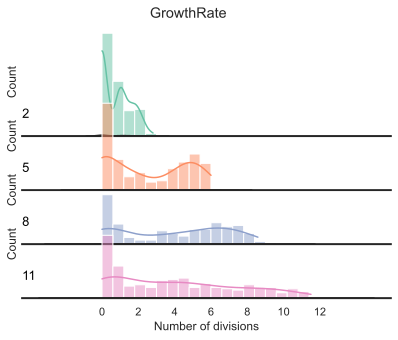

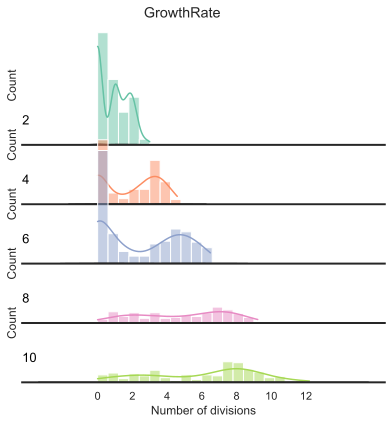

In [93]:

#---------------------------------------------
#Load Data
#---------------------------------------------
print("Load data: ")
#put your path here
path_to_table =  cwd+'Paper/data/processed/RAR014/Colony_count_quantified/FinalTable/'

#Get all mask files
all_txt_files = list(filter(lambda x: x.endswith('.txt'), os.listdir(path_to_table)))
all_txt_files = sorted(all_txt_files)

# set up iniitial df

df = pd.read_csv(path_to_table+all_txt_files[0], sep=",")
df['ID'] = 1
df['Day'] = 8
for i in range(1,len(all_txt_files)):
    
    if i < 4:
        day = 8
    elif i < 7:
        day = 2
    elif i < 11:
        day = 5
    elif i < 15:
        day = 11    
        
    df_hold = pd.read_csv(path_to_table+all_txt_files[i], sep=",")
    df_hold['ID'] = i+1
    df_hold['Day'] = day
    df = pd.concat([df,df_hold])
    
# Calculate any metric you want on the dataframe
df['Colony_area_per_number_of_cells'] = df.Colony_area/df.number_of_cells

print('Read ' + str(len(all_txt_files)) + ' files!')

#---------------------------------------------
#Plot Data
#---------------------------------------------

# Remove clones with less than # cells
df_all = df[df.number_of_cells >0]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

#df_all = df_all[df.Density < 6000]

df_all['GrowthRate'] = np.log2(df_all.number_of_cells)
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="Day", hue="Day", aspect=5, height=1.2)
g.map_dataframe(sns.histplot, x="GrowthRate", binwidth=.6, kde=True)


g.map_dataframe(sns.kdeplot, x="GrowthRate", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "GrowthRate")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Number of divisions")
arr = np.array([0,2,4,6,8,10,12])
plt.xticks(arr)
g.despine( left=True)
plt.suptitle('GrowthRate', y=0.98)


path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_C.pdf'
plt.savefig(path_to_save)


#---------------------------------------------
# Replicate
#---------------------------------------------

#put your path here
Days = ("Day2","Day4","Day6","Day8","Day10")
Days_n = [2,4,6,8,10]
path_to_experiment = '/Volumes/4TDATA_RAR/RAR/Shaffer_Scope/RAR023/'
path_to_table = "/Tables/"

# Get all FinalTable... .txt files for each day 
final_paths = [path_to_experiment + s + path_to_table for s in Days]

print("Reading files:")

df = pd.DataFrame()
cnt = 0
for i in final_paths:
    
    print("               Day " + Days[cnt])
    #Get all mask files
    all_txt_files = list(filter(lambda x: x.startswith('FinalTable'), os.listdir(i)))
    all_txt_files = sorted(all_txt_files)
    cnt += 1 
    
    for j in range(0,len(all_txt_files)): 
        
        df_hold = pd.read_csv(i + all_txt_files[j], sep=",")
        df_hold['well_ID'] = j+1
        df_hold['Day'] = Days_n[cnt-1]
        df = pd.concat([df,df_hold])

    print('                            Read ' + str(len(all_txt_files)) + ' files!')
    
# Calculate any metric you want on the dataframe
df['Colony_area_per_number_of_cells'] = df.Colony_area/df.number_of_cells


#---------------------------------------------
#Plot Data
#---------------------------------------------

# Remove clones with less than # cells
df_all = df[df.number_of_cells >0]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

#df_all = df_all[df.Density < 6000]

df_all['GrowthRate'] = np.log2(df_all.number_of_cells)
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="Day", hue="Day", aspect=5, height=1.2)
g.map_dataframe(sns.histplot, x="GrowthRate", binwidth=.6, kde=True)


g.map_dataframe(sns.kdeplot, x="GrowthRate", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "GrowthRate")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Number of divisions")
arr = np.array([0,2,4,6,8,10,12])
plt.xticks(arr)
g.despine( left=True)
plt.suptitle('GrowthRate', y=0.98)


path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_C_replicate.pdf'
plt.savefig(path_to_save)






### 1D-E) Contrast and crop images of KI67, FN1 and Dapi.

In [8]:
# functions 


def plot_channels(u):

    # Make a wider figure so we can fit in subplots
    plt.figure(figsize=(18, 15))

    # Show each of the three channels
    n_channels = len(u)

    for ii in range(n_channels):

        # Subplot indices start at 1
        plt.subplot(2, int(n_channels/2), ii+1)
	    
        # Array indices start at 0
        u_channel = u[ii]
        plt.imshow(u_channel)
        plt.title(f'Channel {ii}')
        plt.axis(False)

    plt.show()

def colorize(u, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if u.ndim > 2 and u.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')
        
    # Rescale the image according to how we want to display it
    u_scaled = u.astype(np.float32) - np.percentile(u, clip_percentile)
    u_scaled = u_scaled / np.percentile(u_scaled, 100 - clip_percentile)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    # Need to make sure we have a channels dimension for the multiplication to work
    u_scaled = np.atleast_3d(u_scaled)
    
    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return u_scaled * color
    
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y


def rescale_by_percent_and_cut_off(u,min_percent= 0,max_percent= 100,min_cut=0,max_cut=0):
    
    if min_cut == 0 and min_cut == 0:
        min_cut = u.min()
        max_cut = u.max()

    
    u[u<=min_cut] = 0  # Subtract the minimum
    u[u>max_cut] = max_cut # Subtract the minimum
    
    u_scaled = u.astype(np.float32) - np.percentile(u, min_percent)
    u_scaled = u_scaled / np.percentile(u_scaled, max_percent)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    
#     u_divided = u / max_cut  # Divide by new max
    u_inf = np.iinfo(u.dtype)
    u_multiplied = u_scaled * (2**u_inf.bits) # Multiply by dtype max
    
    u_final = u_scaled#exposure.rescale_intensity(u_rescaled, in_range=tuple(percentiles))
    return u_multiplied

def crop_im(u,y1,y2,x1,x2):

    n_channels = len(u)

    u_crop= (u[0][y1:y2,x1:x2],)

    if n_channels > 1:
        for i in range(1,n_channels):
                u_crop = u_crop + (u[i][y1:y2,x1:x2],)

    u_crop = np.stack(u_crop)

    return u_crop


def scalebar(ax,microns,Image_pixel_size):

    scalebar = AnchoredSizeBar(ax.transData,
                               microns/Image_pixel_size, str(microns) + 'um', 'lower right',
                               pad=0.1,
                               color='k',
                               frameon=False,
                               size_vertical=1,
                          bbox_to_anchor=Bbox.from_bounds(0, 0, 1, 1),
                          bbox_transform=ax.figure.transFigure)

    ax.add_artist(scalebar)

def plot_and_save(im_c_c,path_to_save,microns,Image_pixel_size,fig_title,multi):
    fig ,ax= plt.subplots()
    fig.suptitle(fig_title)
    if multi == 1:
        plt.imshow(im_c_c)
    else:
        plt.imshow(im_c_c, cmap='gray')
        
    plt.axis(False)
    scalebar(ax,microns,Image_pixel_size)
    plt.show()
    fig.savefig( path_to_save, dpi=1200,format = 'pdf')


In [9]:
# Scale bar

microns = 100
Image_pixel_size = 6.5
objective = 20
Image_pixel_size = Image_pixel_size * 2 / (objective * 1 * 1)
Image_pixel_size

0.65

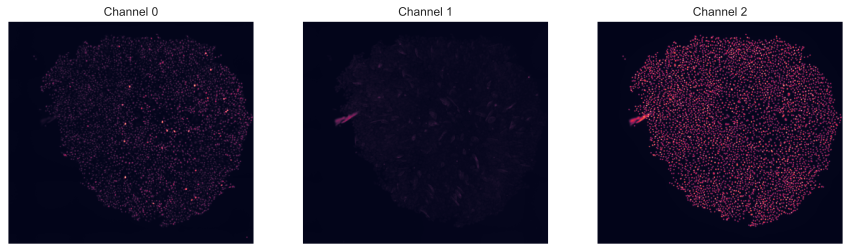

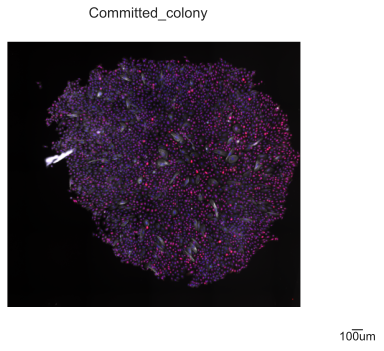

In [89]:
#Load data
paths_im = cwd +"Paper/data/processed/RAR023/Day10/Croped_colonies/Well_4/Cropped_colony_7_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well04_ChannelA647,GFP,DAPI_Seq0003_Stitched.tif"


my_array =  imread(paths_im)


# Make a wider figure so we can fit in subplots
plt.figure(figsize=(15, 6))

im = my_array

# Show each of the three channels
n_channels = len(im)
for ii in range(n_channels):
    
    # Subplot indices start at 1
    plt.subplot(1, n_channels, ii+1)
    
    # Array indices start at 0
    im_channel = im[ii]
    plt.imshow(im_channel)
    plt.title(f'Channel {ii}')
    plt.axis(False)

plt.show()


# large Dapi
im_numb = 2
im = imread(paths_im)


im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


im_numb = 1


im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_numb = 0

im_c_c = rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_KI67 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)


im_white  = colorize(im_FN1 , (1, 1, 1))
im_red  = colorize(im_KI67 , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red, 0, 1)


path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_E.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)

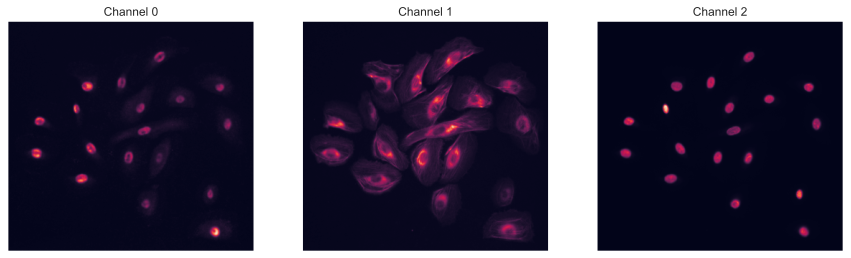

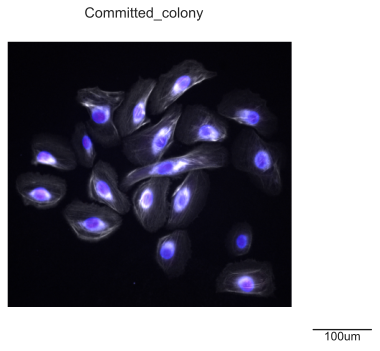

In [90]:

#Load data
paths_im = cwd +"Paper/data/processed/RAR023/Day10/Croped_colonies/Well_9/Cropped_colony_7_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well09_ChannelA647,GFP,DAPI_Seq0008_Stitched.tif"

my_array =  imread(paths_im)


# Make a wider figure so we can fit in subplots
plt.figure(figsize=(15, 6))

im = my_array

# Show each of the three channels
n_channels = len(im)
for ii in range(n_channels):
    
    # Subplot indices start at 1
    plt.subplot(1, n_channels, ii+1)
    
    # Array indices start at 0
    im_channel = im[ii]
    plt.imshow(im_channel[200:900,500:1250])
    plt.title(f'Channel {ii}')
    plt.axis(False)

plt.show()


# large Dapi
im_numb = 2
im = imread(paths_im)

im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c[200:900,500:1250], gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


im_numb = 1


im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_numb = 0

im_c_c = rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_KI67 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)


im_white  = colorize(im_FN1[200:900,500:1250] , (1, 1, 1))
im_red  = colorize(im_KI67[200:900,500:1250] , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red*np.max(im[im_numb])/65535, 0, 1)


path_to_save = cwd + '/Paper/outputs/figures/figure1/figure1_D.pdf'

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,'Committed_colony',1)